/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: covariance is not positive-semidefinite.


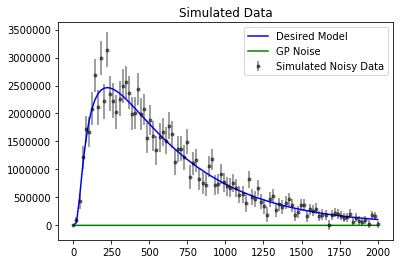

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
from scipy.optimize import minimize, curve_fit

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]
log_paramstrue = np.log(paramstrue)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    name="CTSModel_prior"
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #defining our somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        probA = 1.
        probtau1 = 1.
        probtau2 = 1.
        T=2000. #fix this?????
        if not (self.log_A>np.log(1e4) and self.log_A<np.log(3.5e7)):
            probA = 0.
        if not ((self.log_tau1>np.log(1) and self.log_tau1<np.log(T))):
            probtau1 = 0.
        if not ((self.log_tau2>np.log(1) and self.log_tau2<np.log(T))):
            probtau2 = 0.
        return np.log(probA * probtau1 * probtau2 * np.e)

truemodel = CTSModel_prior(log_A = log_paramstrue[2], log_tau1 = log_paramstrue[3], log_tau2 = log_paramstrue[4])    

#defining the kernel from the celerite RealTerm class so I can set my own prior
class RealTerm_Prior(ce.terms.RealTerm):
    name = "RealTerm_Prior"
    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > -1e5) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)


#defining my simulation method using the kernel
def simulate(x, yerr, model, kernel):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = kernel.get_value(x[:, None] - x[None, :])
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return np.abs(y)

truekernel =  RealTerm_Prior(log_a = log_paramstrue[0], log_c = log_paramstrue[1])


#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = simulate(x, np.zeros(len(x)), truemodel, truekernel)
yerrscale = 2e2
yerr = np.sqrt(ytrue) * yerrscale
plt.figure()
plt.plot(x, ytrue, 'b-', label = "Desired Model")

ysim = simulate(x, yerr, truemodel, truekernel)

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.plot(x, ytrue-truemodel.get_value(x), 'g-', label = "GP Noise")

plt.title("Simulated Data")
plt.legend()

plt.show()


In [2]:
#guessing initial model parameters
guess = np.array([np.log(2.5e6), np.log(50), np.log(100)])
model = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])

Initial log-likelihood: -2331.56969428
True log-likelihood: -1319.89643325
Final log-likelihood: -1319.06127587
Optimized log-parameters: [  5.2469838    2.30258509  15.02181182   4.58721182   6.1829825 ]
True log-parameters: [  6.90775528  -4.60517019  14.97866137   4.60517019   6.2146081 ]


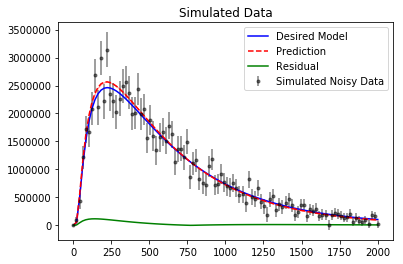

In [3]:
#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(500), log_c = np.log(10))

gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

gp.set_parameter_vector(log_paramstrue)
print("True log-likelihood: {0}".format(gp.log_likelihood(ysim)))

gp.set_parameter_vector(initial_params)
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print ("Optimized log-parameters: " + str(soln.x))
print ("True log-parameters: " + str(log_paramstrue))
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [4]:
paramstart = soln.x
gp.set_parameter_vector(paramstart)
gp.compute(x, yerr)
#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    ll = gp.log_likelihood(y)
    result = ll + lp
    
    if not (np.isfinite(lp)):
        return -np.inf
    if np.isnan(ll)==True:
        return -np.inf
    return result


#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/7500.))



In [5]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee
import corner

ndim = 5
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)


(array([[ -3.86676474e+04,   4.57836885e+00,   1.49526488e+01,
           4.58906109e+00,   6.22912859e+00],
        [ -4.10034323e+03,   5.35201061e-01,   1.49523472e+01,
           4.47269083e+00,   6.23710164e+00],
        [ -2.52636397e+04,  -2.63662318e+00,   1.50366347e+01,
           4.65657561e+00,   6.16085886e+00],
        [ -3.11776769e+04,  -1.47005224e+00,   1.50559847e+01,
           4.66269112e+00,   6.15668989e+00],
        [ -7.70378555e+03,   3.62277567e+00,   1.49989677e+01,
           4.59523683e+00,   6.21708297e+00],
        [ -3.55705787e+04,   3.88108403e+00,   1.49405340e+01,
           4.53965116e+00,   6.23319704e+00],
        [ -7.02225297e+03,   4.07153603e+00,   1.50143166e+01,
           4.58441234e+00,   6.19002071e+00],
        [ -8.82564730e+04,   3.94885666e+00,   1.49570294e+01,
           4.54600189e+00,   6.23800211e+00],
        [ -3.86247689e+04,  -5.76844991e-01,   1.50256508e+01,
           4.66202112e+00,   6.15737643e+00],
        [ -1.295658

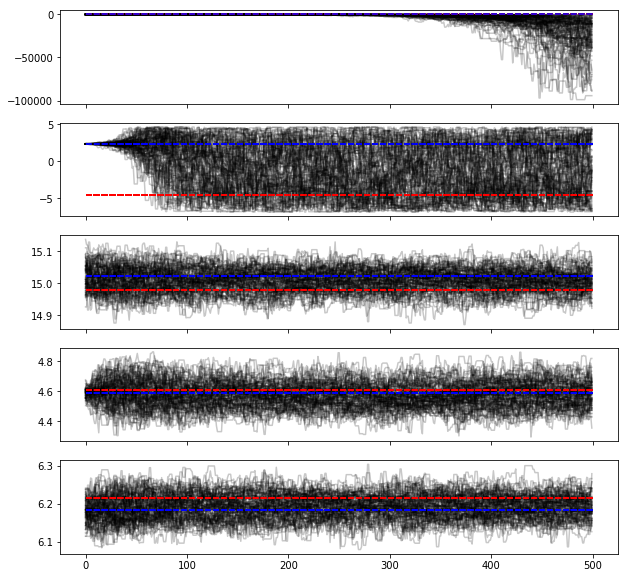

In [6]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramstrue[j] * np.ones(len(xline))
        optval = soln.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

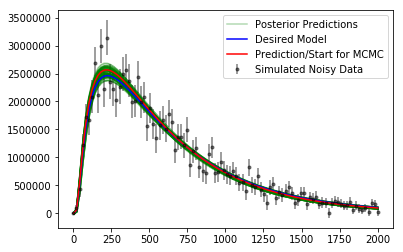

In [7]:
#plotting a sampling of results from emcee MCMC along with my previous work

labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gp.set_parameter_vector(params)
    
    ymc, ymcvar = gp.predict(ysim, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction/Start for MCMC")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

            
plt.legend()    
plt.show()

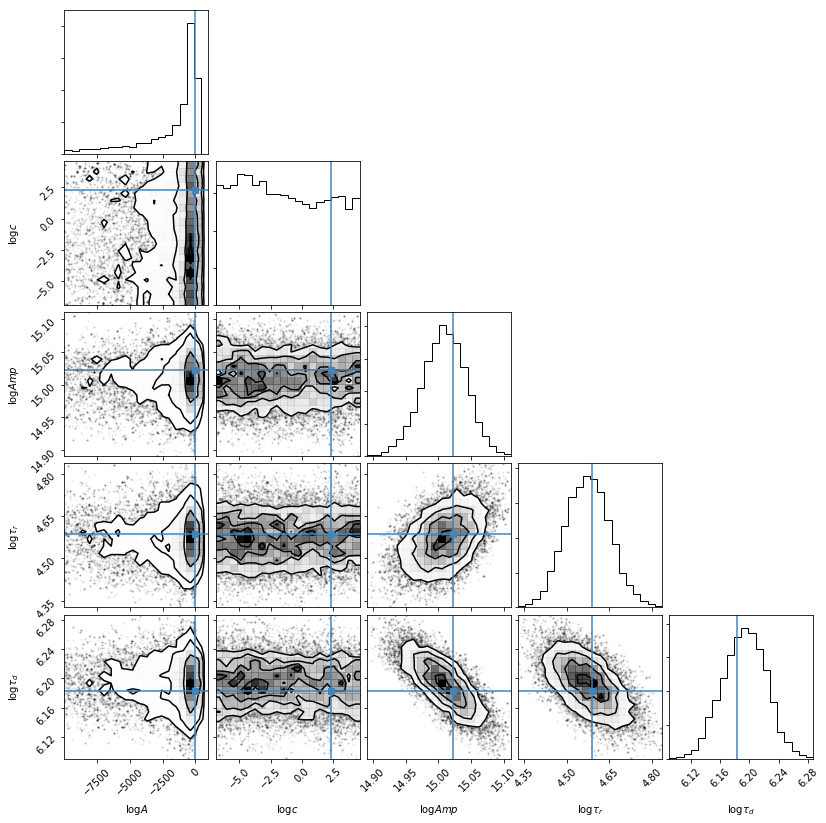

In [8]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = soln.x, range=[(-1e4,1e3),.99999,.999,.999,.999])
plt.show()

 In Inglis & Dominique, 2014, the PSD model for the detection of a QPO (which, in fourier space, is a gaussian component) is given by:
 
 \begin{equation*}
 S_B = S_A + B exp \left(\frac{-(\ln f - \beta)^2}{2 \sigma^2} \right)
 \end{equation*}
 
 Where $S_A$ corresponds to the PSD of the flare envelope, and the remainder is the Gaussian term from the QPO, with $B$ corresponding to the amplitude, the log-frequency location corresponding to $\beta$, and the width of the distrubution by $\sigma$.

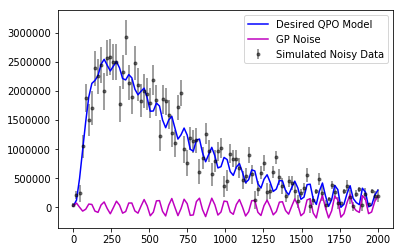

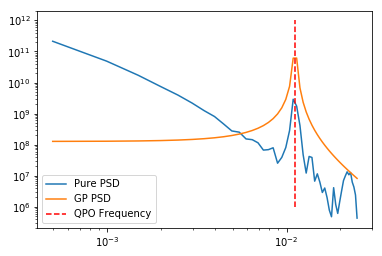

In [9]:
paramsq = [1e9, 1e2, 0.07, 3.2e+06, 1e+02, 5e+02]
log_paramsq = np.log(paramsq)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    name="CTSModel_prior"
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #defining our somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        probA = 1.
        probtau1 = 1.
        probtau2 = 1.
        T=2000.
        if not (self.log_A>np.log(1e4) and self.log_A<np.log(3.5e7)):
            probA = 0.
        if not ((self.log_tau1>np.log(1) and self.log_tau1<np.log(T))):
            probtau1 = 0.
        if not ((self.log_tau2>np.log(1) and self.log_tau2<np.log(T))):
            probtau2 = 0.
        return np.log(probA * probtau1 * probtau2 * np.e)


class SHOTerm_Prior(ce.terms.SHOTerm):
    name = "SHOTerm_Prior"
    def log_prior(self):
        prob_S0 = 1.
        prob_Q = 1.
        prob_omega0 = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_S0 > -10) and (self.log_S0 < 25)):
            prob_S0 = 0.
        if not (self.log_Q > -10 and self.log_Q < 20):
            prob_Q = 0.
        if not (self.log_omega0 > -10 and self.log_omega0 < 20):
            prob_omega0 = 0.
        return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
    
truemodelq = CTSModel_prior(log_A = log_paramsq[3], log_tau1 = log_paramsq[4], log_tau2 = log_paramsq[5])        
truekernelq = SHOTerm_Prior(log_S0 = log_paramsq[0], log_Q = log_paramsq[1], log_omega0 = log_paramsq[2])

plt.figure()
ytrueq = simulate(x, np.zeros(len(x)), truemodelq, truekernelq)
plt.plot(x, ytrueq, 'b-', label = "Desired QPO Model")
yerrscale = 2e2
yerr = np.sqrt(ytrueq) * yerrscale
ysimq = simulate(x, yerr, truemodelq, truekernelq)
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")
gpnoiseq = ytrueq-truemodelq.get_value(x)
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.legend()
plt.show()



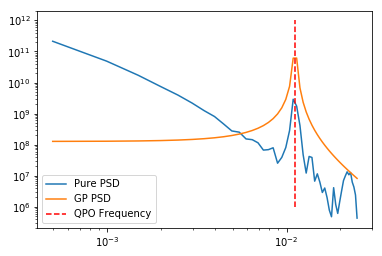

In [24]:
fig = plt.figure()
w_0 = paramsq[2] * np.ones(100) /(np.pi * 2)
yline = np.logspace(6,12,100)
f = np.fft.rfftfreq(len(x),x[1]-x[0])

fft = np.array(np.fft.rfft(ytrueq))
fft *= np.conj(fft)
power_fft = fft.real / (len(x)**2)

fft2 = np.array(np.fft.rfft(ysimq))
fft2 *= np.conj(fft2)
power_fft2 = fft2.real / (len(x)**2)

gpsd = truekernelq.get_psd(2*np.pi*f)/(2*np.pi)
plt.loglog(f, power_fft, label = "Pure PSD")
#plt.loglog(f, power_fft2, label = "Noisy PSD")
plt.loglog(f, gpsd, label="GP PSD")
plt.loglog(w_0, yline, "r--", label="QPO Frequency")
plt.legend()
plt.show()

Guessing startpoints...
Guessed start
Initial log-likelihood: -2930.89568515
True log-likelihood: -1348.3635173
Final log-likelihood: -1405.25058903
Initial log-parameters: [ 18.05550825  -0.93167057  -1.9341459   12.67295191   3.74407562
   3.19755763]
Optimized log-parameters: [ 15.34152907   9.72568677   2.94308478  12.67300183   3.83941653
   4.5864993 ]
True log-parameters: [ 20.72326584   4.60517019  -2.65926004  14.97866137   4.60517019
   6.2146081 ]


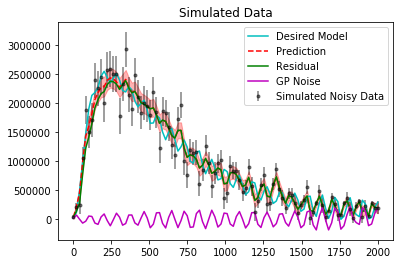

In [10]:
#initializing kernal and GP

logparamsg = np.random.normal(loc=log_paramsq, scale = np.sqrt(np.abs(log_paramsq)))
print "Guessing startpoints..."
while(True):
    try:
        kernelq = SHOTerm_Prior(log_S0 = logparamsg[0], log_Q = logparamsg[1], log_omega0 = logparamsg[2])
        guess = logparamsg[3:]
        modelq = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])
        break
    except(ValueError):
        logparamsg = np.random.normal(loc=log_paramsq, scale = np.sqrt(np.abs(log_paramsq)))
print "Guessed start"

gpq = ce.GP(kernelq, mean = modelq, fit_mean = True)
gpq.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))

#setting initial terms and then optimizing
initial_params = gpq.get_parameter_vector()
bounds = gpq.get_parameter_bounds()

gpq.set_parameter_vector(log_paramsq)
print("True log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))

gpq.set_parameter_vector(initial_params)
solnq = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysimq, gpq))

nit=0
while solnq.success==False:
    nit+=1
    print("Attempt "+str(nit)+"\tParams: " + str(soln.x))
    params = samplepdf(solnq.x)
    try:
        solnq = minimize(neg_log_like, params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysimq, gpq))
    except(RuntimeError):
        print "Whoops"

gpq.set_parameter_vector(solnq.x)
modelq.set_parameter_vector(solnq.x[3:])
print("Final log-likelihood: {0}".format(-solnq.fun))
print ("Initial log-parameters: " + str(logparamsg))
print ("Optimized log-parameters: " + str(solnq.x))
print ("True log-parameters: " + str(log_paramsq))
ytestq, yvarq = gpq.predict(ysimq, x, return_var=True)
ystdq = np.sqrt(yvarq)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrueq, 'c-', label = "Desired Model")
plt.plot(x, ytestq, 'r--', label = "Prediction")
plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytestq-modelq.get_value(x)), 'g-', label = "Residual")
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [11]:
paramstartq = solnq.x
gpq.set_parameter_vector(paramstartq)
gpq.compute(x, yerr)

def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    try:
        ll = gp.log_likelihood(y)
    except RuntimeError:
        ll = np.nan
    result = ll + lp
    
    if not (np.isfinite(lp)):
        return -np.inf
    if np.isnan(ll)==True:
        return -np.inf
    return result

def samplepdf(params, scale=1):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params))*scale)


ndim = 6
nwalkers = 100
nsteps = 1500
start = [samplepdf(paramstartq,1e-10) for i in range(nwalkers)]
print "Picking start..."
for i in range(nwalkers):
    attempt = 0
    while(log_probability(start[i], ysimq, gpq)==-np.inf):
        attempt += 1
        start[i] = samplepdf(paramstartq, 1)
print "Sampling..."
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysimq, gpq))
sampler.run_mcmc(start, nsteps)


Picking start...
Sampling...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(array([[ 15.19473588,   9.79278588,   2.9429104 ,   9.35896587,
           0.36467249,   0.68591871],
        [ 12.87001526,   7.9063384 ,   2.93026191,  14.96287549,
           4.57798906,   6.26141301],
        [ 10.00909231,   9.67121165,   2.95569527,  14.92565774,
           4.51123631,   6.27754949],
        [ 12.30626323,   9.57721851,   2.9301091 ,  14.9368832 ,
           4.69521567,   6.31015519],
        [ 10.33463189,  10.91306472,   2.96285891,  14.98449986,
           4.53558576,   6.23558958],
        [ 10.83993406,  11.57580823,   2.94663555,  14.9994012 ,
           4.83861936,   6.22341575],
        [ 10.82444682,   9.74734735,   2.97876323,  14.95213839,
           4.51037353,   6.30077356],
        [ 11.10408045,   9.22238842,   2.94657337,  14.93304006,
           4.53535688,   6.2922524 ],
        [ 10.67290443,  10.76933649,   2.94661827,  14.94226428,
           4.720383  ,   6.233316  ],
        [ 24.66684816,  -4.51707644,   2.88082931,  14.95639966,
        

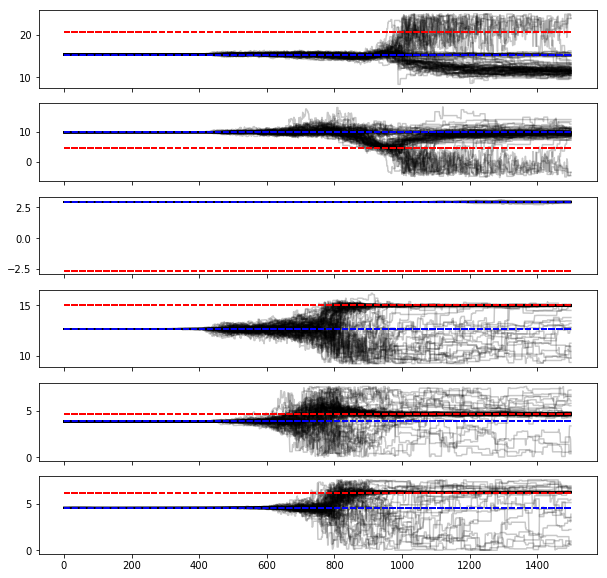

In [12]:
fig, axarr = plt.subplots(ndim, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramsq[j] * np.ones(len(xline))
        optval = solnq.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

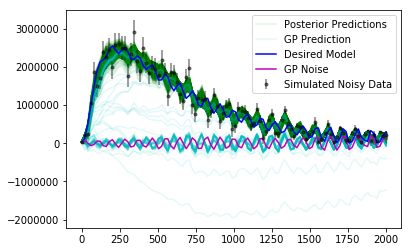

In [13]:
labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gpq.set_parameter_vector(params)
    modelq.set_parameter_vector(params[3:])
    ymc, ymcvar = gpq.predict(ysimq, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    gpnoisemc = ymc - modelq.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.1, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.1, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', label = "GP Prediction", alpha=0.1)
            labeled = True
        else: 
            plt.plot(x, ymc, 'g-', alpha = 0.1)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.1, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', alpha = 0.1)

plt.plot(x, ytrueq, 'b-', label = "Desired Model")
#plt.plot(x, ytestq, 'r-', label = "Prediction/Start for MCMC")
#plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")


            
plt.legend()    
plt.show()

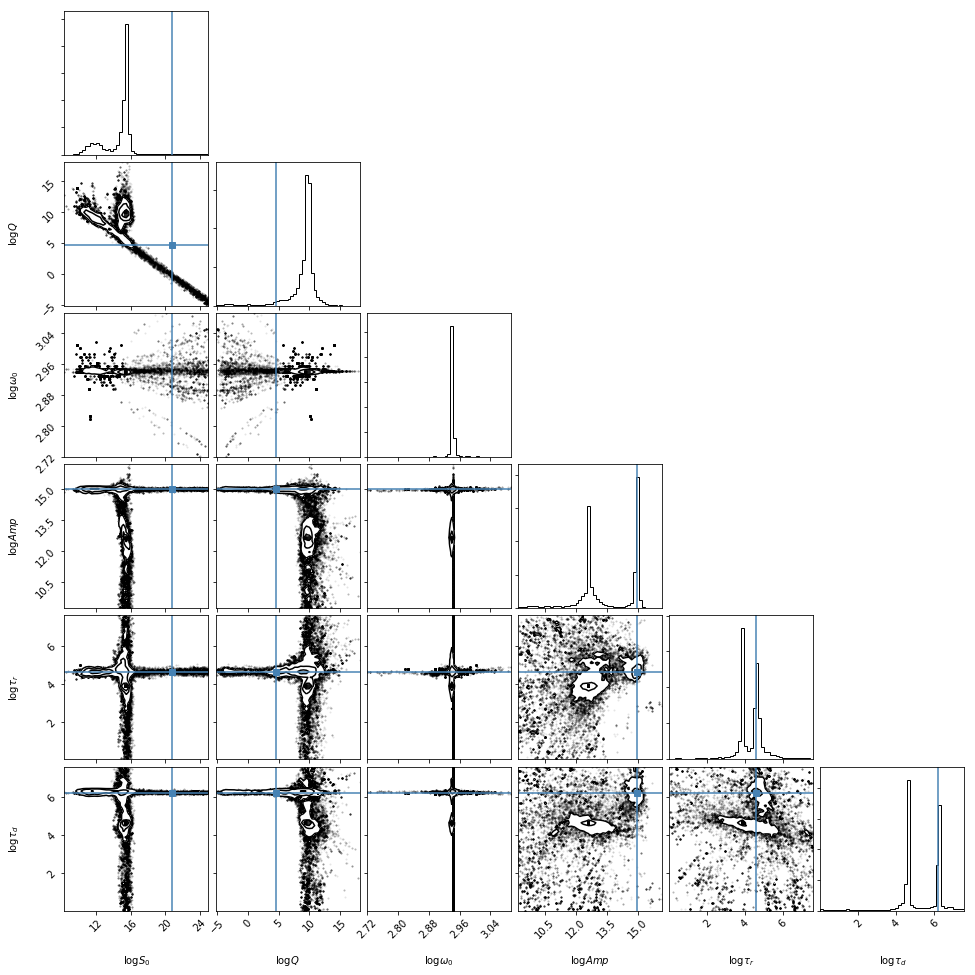

In [14]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, bins=50, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_paramsq, range = [1,1,1,1,1,1])
plt.show()

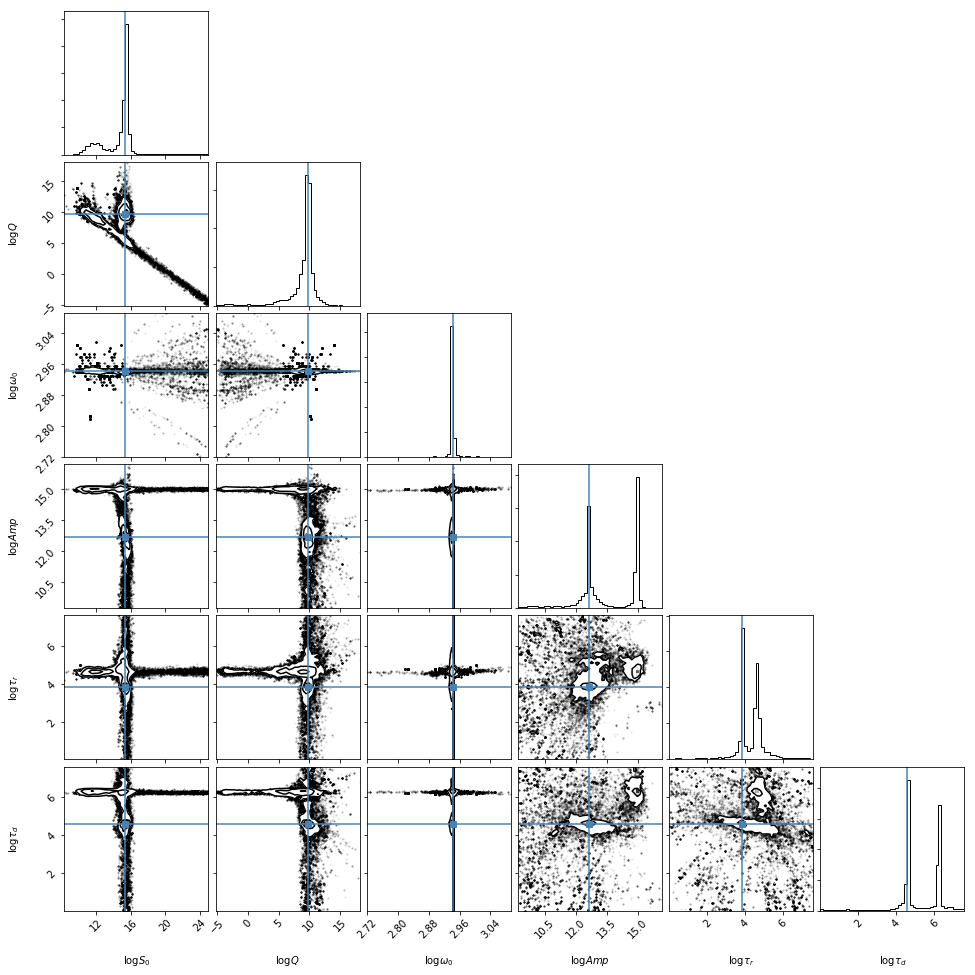

In [15]:
fig = corner.corner(flat_samples, bins = 50, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = solnq.x, range = [1,1,1,1,1,1])
plt.show()

In [16]:
#writing things to file
import os
import pickle
fname = "Data/Test1"
write = True
simulated = True

try:
    if(os.path.exists(fname)==True):
        raise NameError('DirectoryExists')
    os.makedirs(fname)
except NameError:
    #overwrite = raw_input("Error: Directory " + fname + " exists, overwrite?(y/n) ")
    overwrite ='y'
    if overwrite=='y':
        write=True
    else:
        write=False


def save_obj(obj, loc):
    with open(loc + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(loc):
    with open(loc + '.pkl', 'rb') as f:
        return pickle.load(f)

if(write==True):
    datafile = open(fname+"/lightcurve.txt", 'w+')
    for i in range(len(ysimq)):
        datafile.write(str(x[i])+'\t'+str(ysimq[i]) + '\t' + str(yerr[i])+'\n')
    datafile.close()
   

    infodict= {'params': paramsq, 'soln':solnq, 'chaindim':[nwalkers, nsteps, ndim]}
    if simulated==True:
        save_obj(truemodelq, fname+"/truemodel")
        save_obj(truekernelq, fname+"/truekernel")
    save_obj(modelq, fname+"/model")
    save_obj(kernelq, fname+"/kernel")
    save_obj(infodict, fname+"/info")
    save_obj(sampler.chain, fname+"/chain")

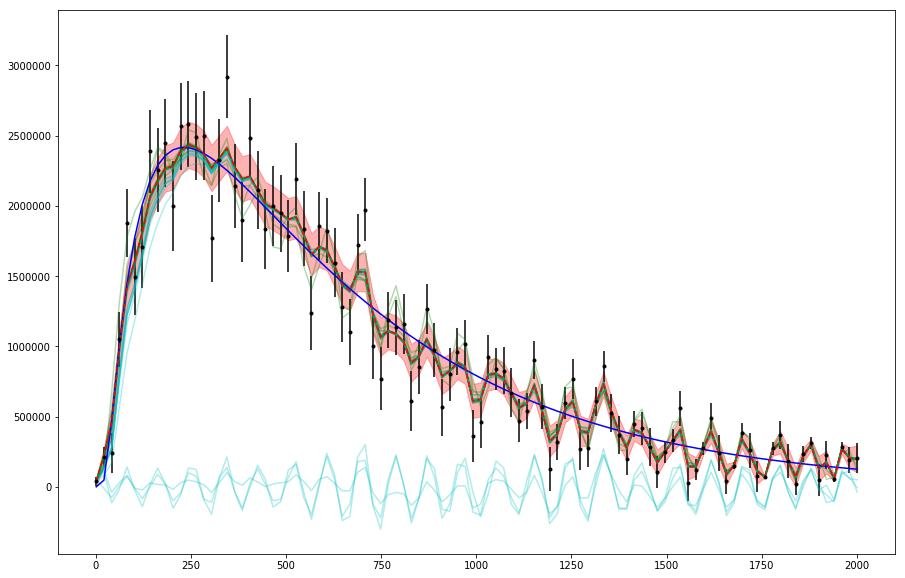

In [18]:
#reading things from file
plt.figure(figsize=(15,10))
xr,yr, yerrr = np.loadtxt(fname + '/lightcurve.txt',  unpack=True)
plt.errorbar(xr,yr, yerr=yerr, fmt='k.')


chain = load_obj(fname+'/chain')
modelload = load_obj(fname+'/model')
kernelload = load_obj(fname+'/kernel')
dictload = load_obj(fname+"/info")
modelload.set_parameter_vector(dictload['soln'].x[3:])
gpload = ce.GP(kernelload, mean = modelload, fit_mean = True)
gpload.compute(x, yerr)
labeled = False
ypredict, yvar = gpload.predict(yr, xr, return_var=True)
ystd = np.sqrt(yvar)
for i in range(nsteps/100):
    params = chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gpload.set_parameter_vector(params)
    modelload.set_parameter_vector(params[3:])
    ymc, ymcvar = gpload.predict(yr, xr, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    gpnoisemc = ymc - modelload.get_value(xr)
    if not np.isnan(ymc).any():
            plt.plot(xr, ymc, 'g-', alpha = 0.3)
            plt.plot(xr, gpnoisemc, 'c-', alpha=0.3)


plt.plot(xr, modelload.get_value(xr), 'b-')

gpload.set_parameter_vector(dictload['soln'].x)

plt.plot(xr, ypredict, 'r--')
plt.fill_between(x, ypredict+ystd, ypredict-ystd, color='r', alpha=0.3, edgecolor='none')
    
plt.show()